In [8]:
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import os

from typing import List, Optional

In [116]:
def fetch_project_runs(project_name: str) -> pd.DataFrame:
    """
    Fetch all runs from a specified W&B project and convert metrics to a DataFrame.
    If a cached version exists, load that instead.
    """
    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)
    cache_path = f'data/{project_name}_runs.parquet'
    
    # Check if cached data exists
    if os.path.exists(cache_path):
        print(f"Loading cached data for {project_name}")
        return pd.read_parquet(cache_path)
    
    print(f"Fetching data from W&B for {project_name}")
    api = wandb.Api()
    runs = api.runs(f"exomatt-exo-labs/{project_name}")
    
    all_data = []
    for run in runs:
        history = pd.DataFrame(run.scan_history())
        history['run_name'] = run.name
        all_data.append(history)
    
    df = pd.concat(all_data) if all_data else pd.DataFrame()
    
    # Save the DataFrame
    if not df.empty:
        df.to_parquet(cache_path)
        print(f"Saved data to {cache_path}")
    
    return df

def plot_metric(df: pd.DataFrame, metric: str, project_name: str, x_range: Optional[tuple] = None, exclude_runs: Optional[List[str]] = None):
    """
    Plot a specific metric for all runs in a project
    """
    plt.figure(figsize=(10, 6))
    
    run_names = df['run_name'].unique()
    run_names = sorted(run_names)
    for run_name in run_names:
        if exclude_runs and run_name in exclude_runs:
            continue
        run_data = df[df['run_name'] == run_name][['_step', metric]].dropna()
        plt.plot(run_data['_step'], run_data[metric], label=run_name)
    
    if x_range:
        plt.xlim(x_range)
        # Get y values only within x_range
        y_values = []

        for run_name in df['run_name'].unique():
            if exclude_runs and run_name in exclude_runs:
                continue
            run_data = df[df['run_name'] == run_name][['_step', metric]].dropna()
            mask = (run_data['_step'] >= x_range[0]) & (run_data['_step'] <= x_range[1])
            y_values.extend(run_data[mask][metric].tolist())
        if y_values:
            # Set y limits with small padding
            y_min, y_max = min(y_values), max(y_values)
            padding = (y_max - y_min) * 0.05
            plt.ylim(y_min - padding, y_max + padding)
        
    plt.title(f"{metric}")
    plt.xlabel("Step")
    plt.ylabel(metric)
    plt.legend(loc='upper right', framealpha=0.7)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [117]:
project_name = 'owt_diloco_H_correlation'
x_range = (3000, 10000)
df = fetch_project_runs(project_name)

Loading cached data for owt_diloco_H_correlation


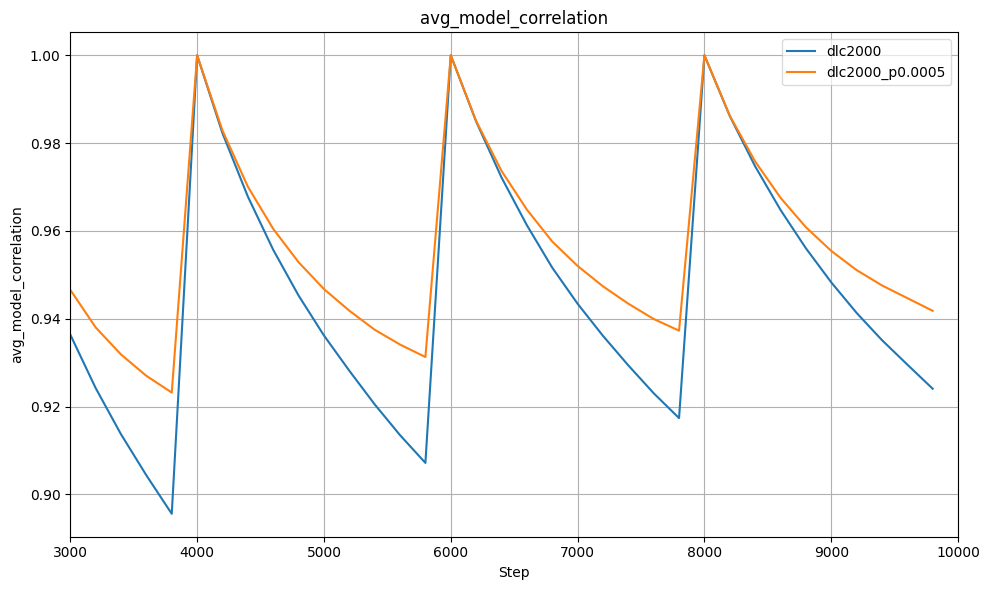

In [118]:
plot_metric(df, 'avg_model_correlation', project_name, x_range, ['dlc5000_p0.0005', 'dlc5000_p0.0002_small', 'dlc5000_small', 'dlc5000_p0.0002'])

Loading cached data for owt_diloco_H_full


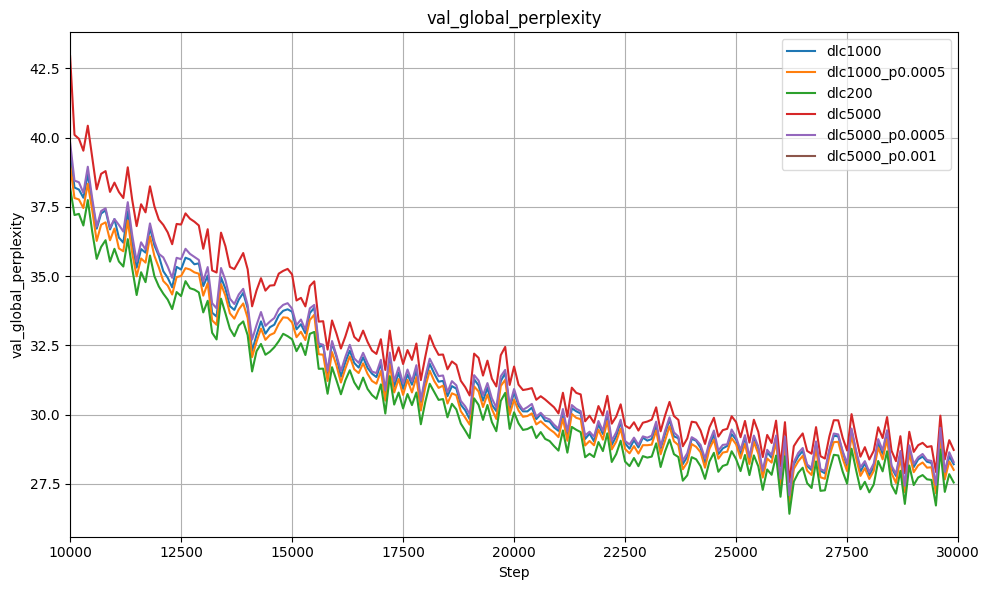

In [119]:
project_name = 'owt_diloco_H_full'
x_range = (10000, 30000)
df = fetch_project_runs(project_name)

plot_metric(df, 'val_global_perplexity', project_name, x_range)

Loading cached data for owt_diloco++_regularising_full


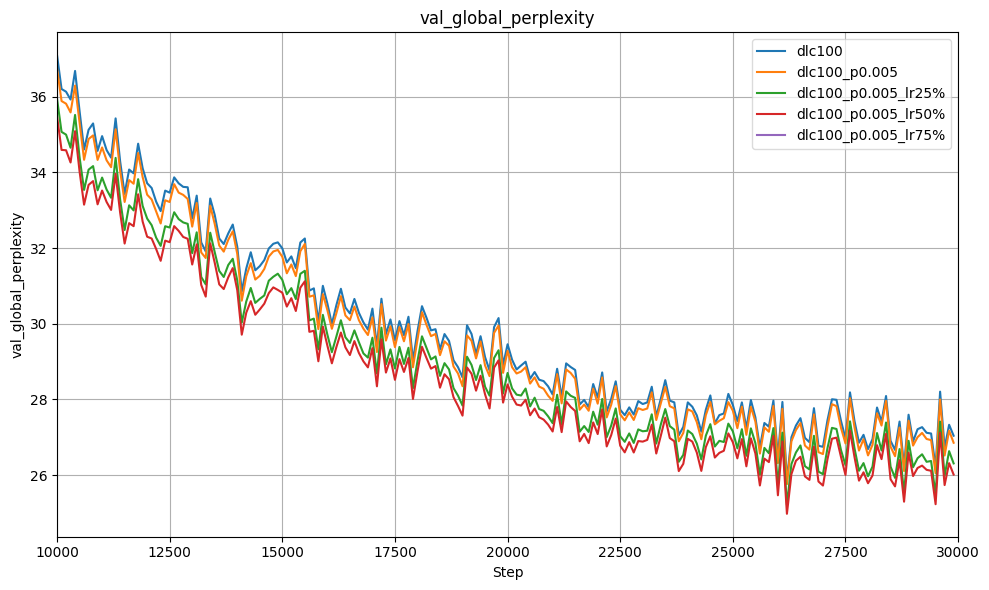

In [121]:
project_name = 'owt_diloco++_regularising_full'
x_range = (10000, 30000)
df = fetch_project_runs(project_name)

plot_metric(df, 'val_global_perplexity', project_name, x_range)